In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-Processing

In [3]:
class_names = ['1Rand 1', '1Rand 2', '2Rand 1', '2Rand 2', '5Rand 1', '5Rand 2',
               '5Rand 3', '5Rand 4', '5Rand 5', '10cents 1'
              , '10cents 2', '20cents 1', '20cents 2', '50cents 1', '50cents 2']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
epochs = 20
IMAGE_SIZE = (150, 150)

In [4]:
def load_data(split_ratio=0.8):
    """
    Load the data and split it into training and testing sets.
    """
    dataset_dir = '/content/drive/MyDrive/COMP702Project/south_african_coins33'
    output = []

    images = []
    labels = []

    print("Loading {}".format(dataset_dir))

    # Iterate through each folder corresponding to a category
    for folder in os.listdir(dataset_dir):
        label = class_names_label[folder]

        # Iterate through each image in the folder
        for file in tqdm(os.listdir(os.path.join(dataset_dir, folder))):
            # Get the path of the image
            img_path = os.path.join(os.path.join(dataset_dir, folder), file)

            # Open and resize the image
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE)

            # Append the image and its corresponding label to the output
            images.append(image)
            labels.append(label)

    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')

    # Split the data into training and testing sets
    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, train_size=split_ratio, random_state=42)

    output.append((train_images, train_labels))
    output.append((test_images, test_labels))

    return output

In [5]:
(train_images, train_labels) = load_data()[0]
(test_images, test_labels) = load_data()[1]

Loading /content/drive/MyDrive/COMP702Project/south_african_coins33


100%|██████████| 132/132 [00:01<00:00, 68.18it/s]


Loading /content/drive/MyDrive/COMP702Project/south_african_coins33


100%|██████████| 132/132 [00:01<00:00, 98.22it/s]


In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


In [7]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 738
Number of testing examples: 185
Each image is of size: (150, 150)


In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """

    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

In [10]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

In [11]:
def plotConfusionMatrix(test_labels, pred_labels):
    CM = confusion_matrix(test_labels, pred_labels)
    ax = plt.axes()
    sn.heatmap(CM, annot=True,
               annot_kws={"size": 10},
               xticklabels=class_names,
               yticklabels=class_names, ax = ax)
    ax.set_title('Confusion matrix')
    plt.show()

In [12]:
def getTrainingScores(train_predictions, train_labels ):
    # Convert the predicted probabilities to binary predictions
    pred_labels = np.argmax(train_predictions, axis=1)

    # Calculate the metrics
    accuracy_train = accuracy_score(train_labels, pred_labels)
    precision_train = precision_score(train_labels, pred_labels, average='weighted', zero_division=0)
    recall_train = recall_score(train_labels, pred_labels, average='weighted')
    f1_train = f1_score(train_labels, pred_labels, average='weighted')

    # Print the metrics for the testing set
    print("................Training set scores..............................")
    print("Training set accuracy:", accuracy_train)
    print("Training set precision:", precision_train)
    print("Training set recall:", recall_train)
    print("Training set F1 score:", f1_train)



def getTestScore(test_predictions, test_labels):
    # Convert the predicted probabilities to binary predictions
    pred_labels = np.argmax(test_predictions, axis=1)

    # Calculate the metrics
    accuracy_test = accuracy_score(test_labels, pred_labels)
    precision_test = precision_score(test_labels, pred_labels, average='weighted', zero_division=0)
    recall_test = recall_score(test_labels, pred_labels, average='weighted')
    f1_test = f1_score(test_labels, pred_labels, average='weighted')

    # Print the metrics for the testing set
    print("................Testing set scores..............................")
    print("Testing set accuracy:", accuracy_test)
    print("Testing set precision:", precision_test)
    print("Testing set recall:", recall_test)
    print("Testing set F1 score:", f1_test)


In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

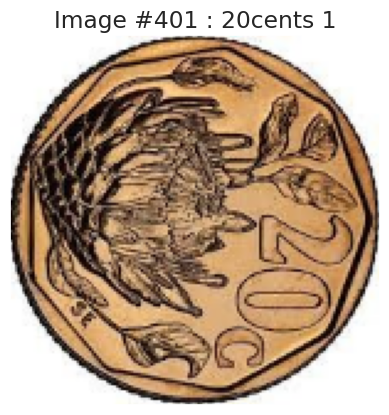

In [14]:
display_random_image(class_names, train_images, train_labels)

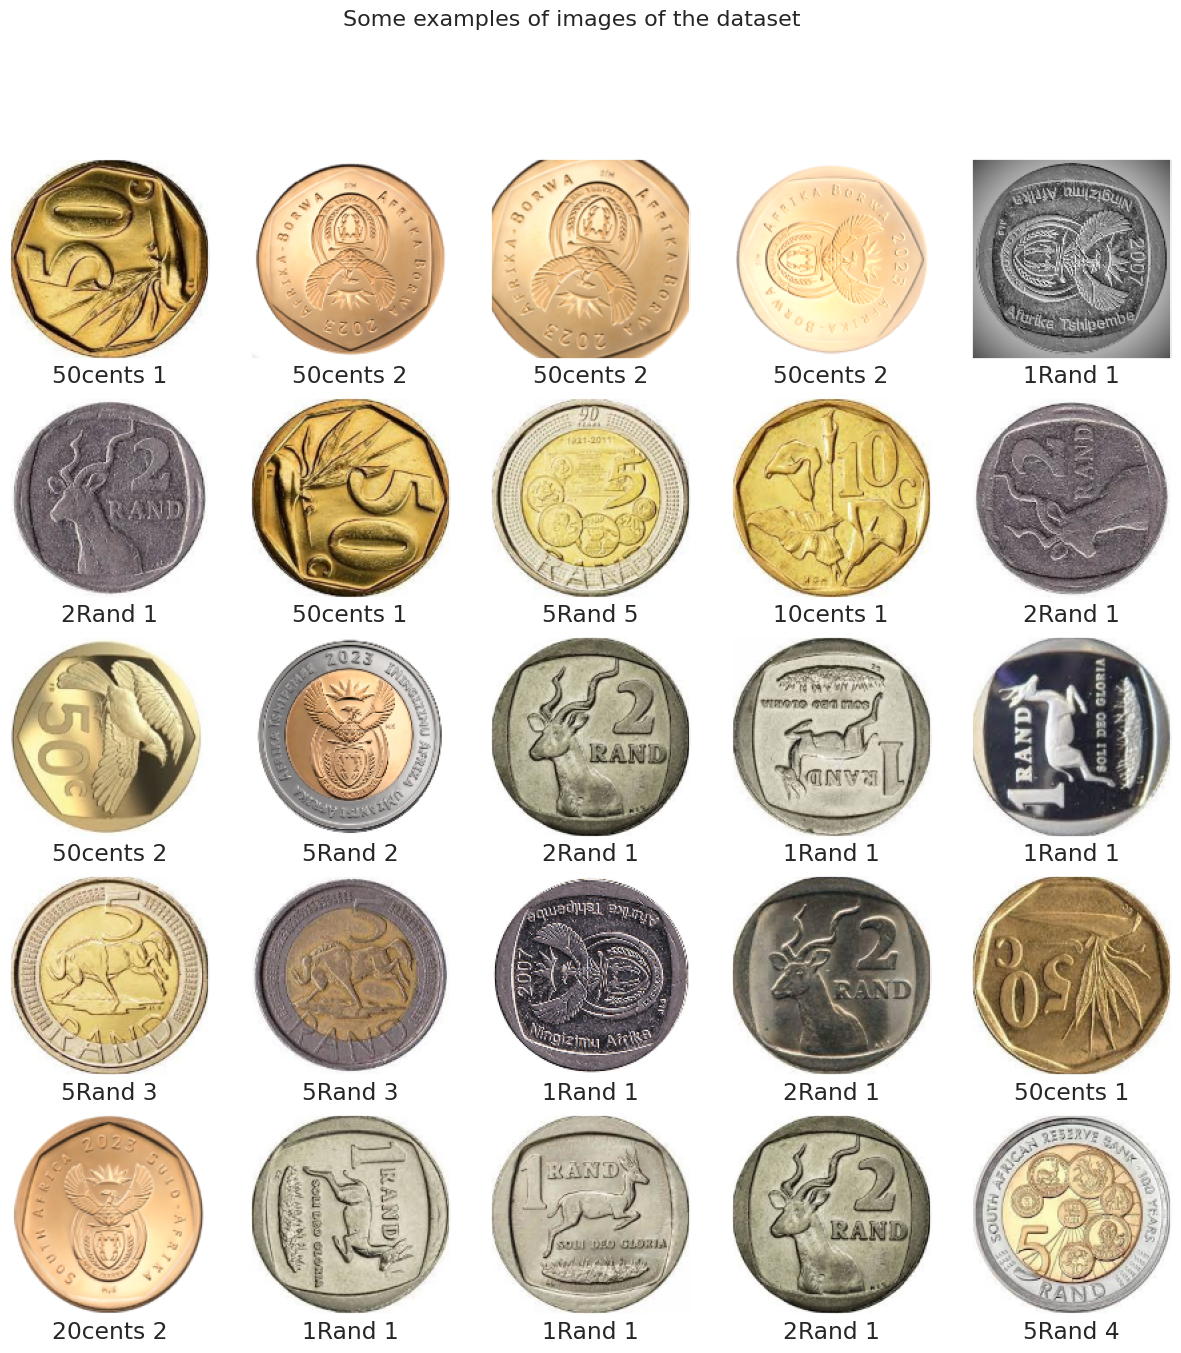

In [15]:
display_examples(class_names, train_images, train_labels)

## CNN Model

In [16]:
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

In [17]:
model_cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model_cnn.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_cnn = ModelCheckpoint('best_cnn_weights.h5', monitor='val_loss', save_best_only=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 flatten (Flatten)           (None, 700928)            0         
                                                                 
 dense (Dense)               (None, 15)                10513935  
                                                                 
Total params: 10,514,831
Trainable params: 10,514,831
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model_cnn.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_cnn])

Epoch 1/20
5/5 [==============================] - 5s 379ms/step - loss: 49.8070 - accuracy: 0.1119 - val_loss: 52.4382 - val_accuracy: 0.0743
Epoch 2/20
5/5 [==============================] - 1s 174ms/step - loss: 47.5613 - accuracy: 0.1000 - val_loss: 30.8967 - val_accuracy: 0.0743
Epoch 3/20
5/5 [==============================] - 3s 687ms/step - loss: 18.3442 - accuracy: 0.2153 - val_loss: 10.3611 - val_accuracy: 0.2973
Epoch 4/20
5/5 [==============================] - 1s 161ms/step - loss: 5.4566 - accuracy: 0.4220 - val_loss: 3.2992 - val_accuracy: 0.4865
Epoch 5/20
5/5 [==============================] - 1s 156ms/step - loss: 1.3993 - accuracy: 0.7254 - val_loss: 1.4189 - val_accuracy: 0.6554
Epoch 6/20
5/5 [==============================] - 4s 892ms/step - loss: 0.7630 - accuracy: 0.8153 - val_loss: 1.2471 - val_accuracy: 0.7365
Epoch 7/20
5/5 [==============================] - 1s 168ms/step - loss: 0.6592 - accuracy: 0.8831 - val_loss: 1.0894 - val_accuracy: 0.7905
Epoch 8/20
5/5

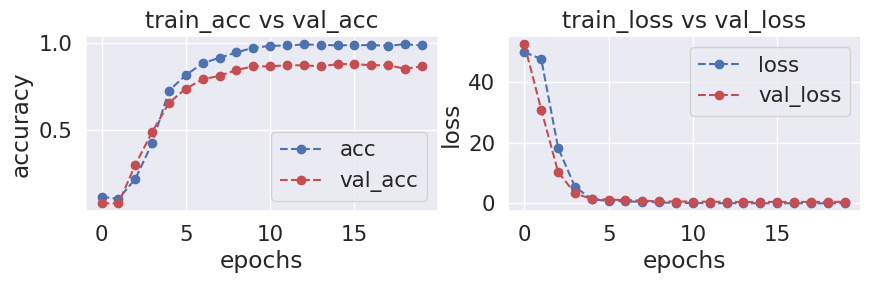

In [19]:
plot_accuracy_loss(history)

In [20]:
test_loss = model_cnn.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 27ms/step - loss: 0.5304 - accuracy: 0.8757


6/6 [==============================] - 0s 8ms/step


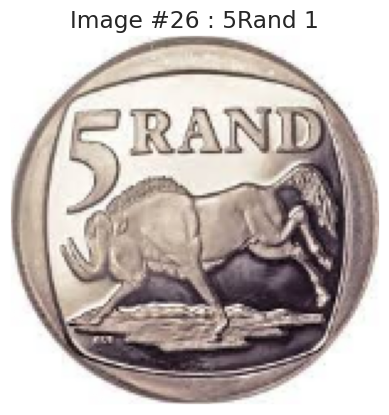

In [21]:
predictions = model_cnn.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

In [22]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.8756756756756757
Testing set precision: 0.8957281457281459
Testing set recall: 0.8756756756756757
Testing set F1 score: 0.8756953204012028


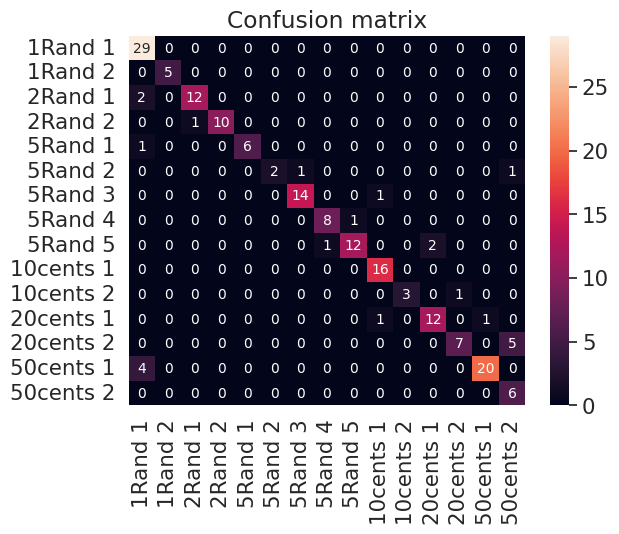

In [23]:
plotConfusionMatrix(test_labels, pred_labels)

24/24 [==============================] - 0s 8ms/step


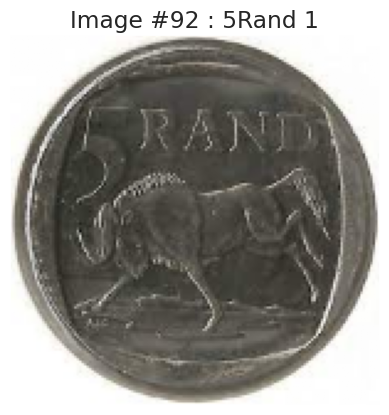

In [24]:
predictions = model_cnn.predict(train_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels)

In [25]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.967479674796748
Training set precision: 0.9678791454879297
Training set recall: 0.967479674796748
Training set F1 score: 0.9672530275199166


## Lenet5 Model

In [26]:
model_lenet5 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])
model_lenet5.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model_lenet5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 69, 69, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 73984)             0         
                                                                 
 dense_1 (Dense)             (None, 120)              

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_lenet5 = ModelCheckpoint('best_lstm_weights.h5', monitor='val_loss', save_best_only=True)

history_lenet5 = model_lenet5.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_lenet5])

Epoch 1/20
5/5 [==============================] - 7s 608ms/step - loss: 2.9436 - accuracy: 0.1186 - val_loss: 2.6079 - val_accuracy: 0.1419
Epoch 2/20
5/5 [==============================] - 1s 315ms/step - loss: 2.5134 - accuracy: 0.1746 - val_loss: 2.4347 - val_accuracy: 0.1689
Epoch 3/20
5/5 [==============================] - 1s 208ms/step - loss: 2.2364 - accuracy: 0.2712 - val_loss: 2.3360 - val_accuracy: 0.2230
Epoch 4/20
5/5 [==============================] - 1s 214ms/step - loss: 1.9617 - accuracy: 0.3932 - val_loss: 1.9332 - val_accuracy: 0.3041
Epoch 5/20
5/5 [==============================] - 3s 718ms/step - loss: 1.5421 - accuracy: 0.4712 - val_loss: 1.4078 - val_accuracy: 0.5676
Epoch 6/20
5/5 [==============================] - 1s 197ms/step - loss: 1.1598 - accuracy: 0.6305 - val_loss: 1.2584 - val_accuracy: 0.6216
Epoch 7/20
5/5 [==============================] - 1s 179ms/step - loss: 0.9198 - accuracy: 0.7017 - val_loss: 0.9732 - val_accuracy: 0.6554
Epoch 8/20
5/5 [====

In [29]:
test_loss = model_lenet5.evaluate(test_images, test_labels)

6/6 [==============================] - 1s 49ms/step - loss: 0.3625 - accuracy: 0.9081


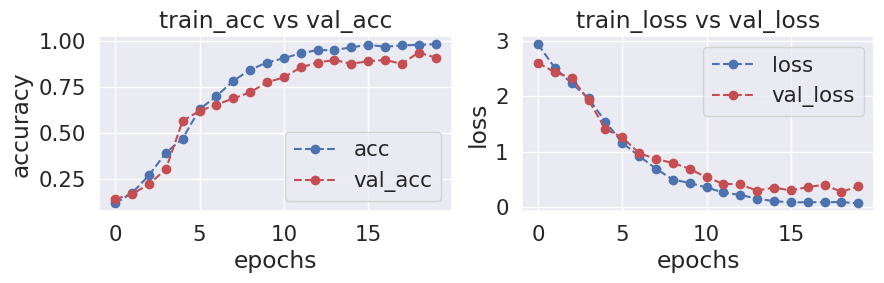

In [30]:
plot_accuracy_loss(history_lenet5)

6/6 [==============================] - 0s 12ms/step


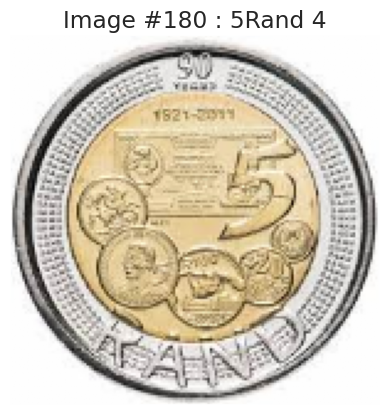

In [31]:
predictions = model_lenet5.predict(test_images)     # Vector of probabilities
pred_labels_2 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_2)

In [32]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.9081081081081082
Testing set precision: 0.918928278928279
Testing set recall: 0.9081081081081082
Testing set F1 score: 0.908343836011369


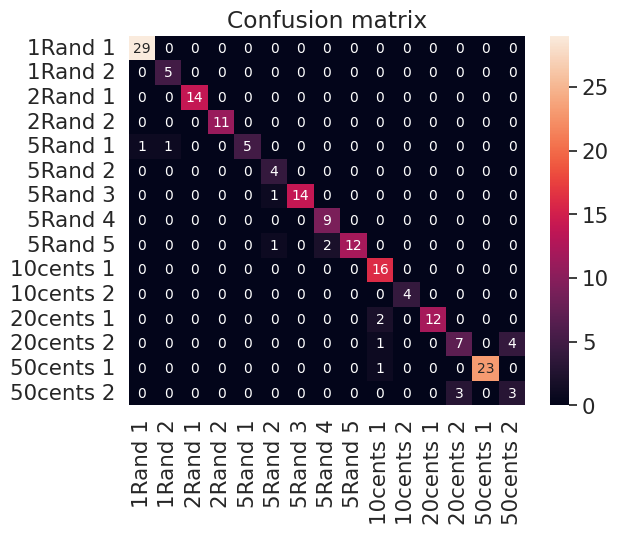

In [33]:
plotConfusionMatrix(test_labels, pred_labels_2)

24/24 [==============================] - 0s 13ms/step


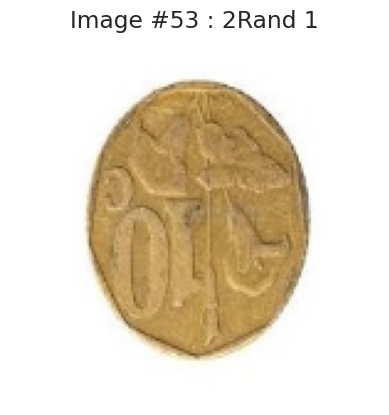

In [34]:
predictions =model_lenet5.predict(train_images)     # Vector of probabilities
pred_labels_2 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_2)

In [35]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.9715447154471545
Training set precision: 0.973676199303559
Training set recall: 0.9715447154471545
Training set F1 score: 0.9710999922346384


## RNN Model

In [36]:
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Reshape((150, 150 * 3), input_shape=(150, 150, 3)),
    tf.keras.layers.SimpleRNN(128, activation='relu'),
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

model_rnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 150, 450)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               74112     
                                                                 
 dense_4 (Dense)             (None, 15)                1935      
                                                                 
Total params: 76,047
Trainable params: 76,047
Non-trainable params: 0
_________________________________________________________________


In [38]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_rnn = ModelCheckpoint('best_cnn_weights.h5', monitor='val_loss', save_best_only=True)
history_rnn = model_rnn.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split = 0.2,callbacks=[early_stopping, model_checkpoint_rnn])

Epoch 1/20
5/5 [==============================] - 4s 348ms/step - loss: 3.2997 - accuracy: 0.0644 - val_loss: 2.7783 - val_accuracy: 0.1014
Epoch 2/20
5/5 [==============================] - 1s 249ms/step - loss: 2.6662 - accuracy: 0.1288 - val_loss: 2.5706 - val_accuracy: 0.1351
Epoch 3/20
5/5 [==============================] - 1s 138ms/step - loss: 2.6032 - accuracy: 0.1441 - val_loss: 2.5709 - val_accuracy: 0.1824
Epoch 4/20
5/5 [==============================] - 1s 138ms/step - loss: 2.5628 - accuracy: 0.1407 - val_loss: 2.5829 - val_accuracy: 0.0811
Epoch 5/20
5/5 [==============================] - 1s 139ms/step - loss: 2.5417 - accuracy: 0.1424 - val_loss: 2.5416 - val_accuracy: 0.1622
Epoch 6/20
5/5 [==============================] - 1s 132ms/step - loss: 2.5270 - accuracy: 0.1644 - val_loss: 2.5404 - val_accuracy: 0.1689
Epoch 7/20
5/5 [==============================] - 1s 134ms/step - loss: 2.5119 - accuracy: 0.1525 - val_loss: 2.5457 - val_accuracy: 0.1014
Epoch 8/20
5/5 [====

In [39]:
test_loss = model_rnn.evaluate(test_images, test_labels)

6/6 [==============================] - 0s 18ms/step - loss: 2.4648 - accuracy: 0.2270


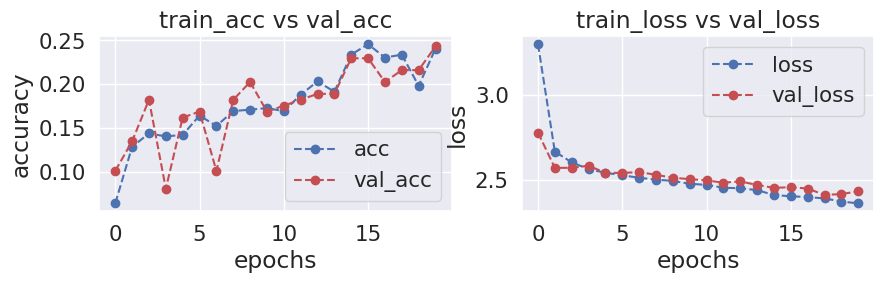

In [40]:
plot_accuracy_loss(history_rnn)

6/6 [==============================] - 0s 17ms/step


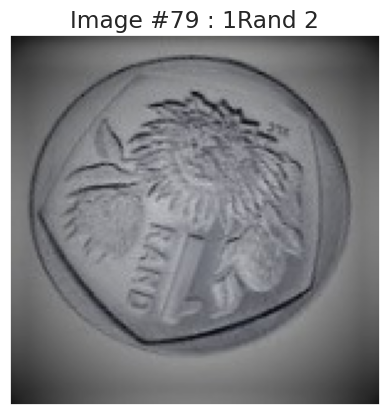

In [41]:
predictions = model_rnn.predict(test_images)     # Vector of probabilities
pred_labels_3 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_3)

In [42]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.22702702702702704
Testing set precision: 0.28787851159532574
Testing set recall: 0.22702702702702704
Testing set F1 score: 0.15596104245419912


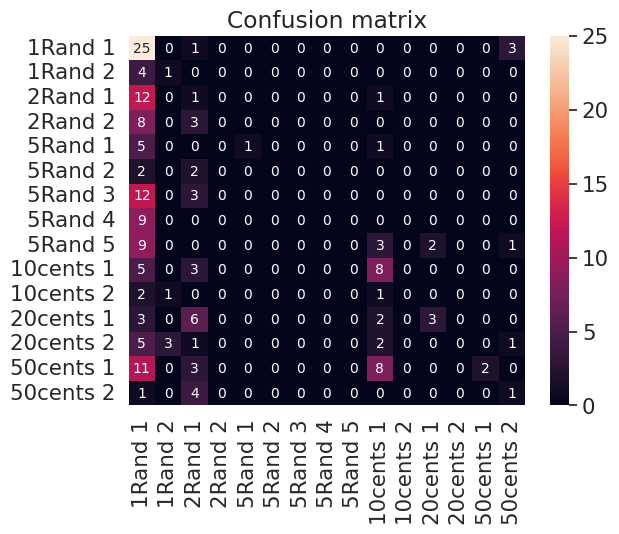

In [43]:
plotConfusionMatrix(test_labels, pred_labels_3)

24/24 [==============================] - 0s 18ms/step


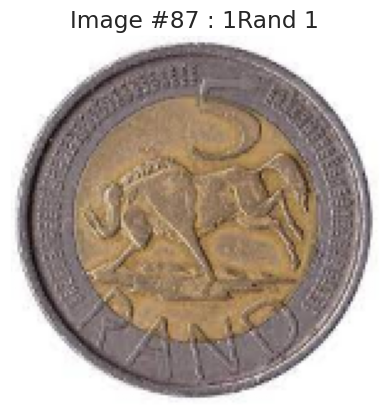

In [44]:
predictions = model_rnn.predict(train_images)     # Vector of probabilities
pred_labels_3 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_3)

In [45]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.2696476964769648
Training set precision: 0.35655770890017335
Training set recall: 0.2696476964769648
Training set F1 score: 0.20931874330849012


# INCEPTION MODEL

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_img = Input(shape=(150, 150, 3))

tower_1 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
tower_1 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
tower_2 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
tower_3 = tf.keras.layers.Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = concatenate([tower_1, tower_2, tower_3], axis=3)
output = tf.keras.layers.Flatten()(output)
output = tf.keras.layers.Dense(nb_classes, activation='softmax')(output)

model_inception = Model(inputs=input_img, outputs=output) # Compile the model

In [47]:
model_inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
# Set up early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_inception = ModelCheckpoint('best_inception_weights.h5', monitor='val_loss', save_best_only=True)

#Summary
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 150, 150, 16  64          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_5 (Conv2D)              (None, 150, 150, 16  64          ['input_1[0][0]']                
                                )                                                             

In [49]:
# Fit the model
history_inception = model_inception.fit(train_images, train_labels, batch_size=128, epochs=epochs, validation_split=0.2, callbacks=[early_stopping, model_checkpoint_inception])

Epoch 1/20
5/5 [==============================] - 11s 1s/step - loss: 112.7924 - accuracy: 0.1203 - val_loss: 157.4967 - val_accuracy: 0.1622
Epoch 2/20
5/5 [==============================] - 1s 189ms/step - loss: 137.4699 - accuracy: 0.1051 - val_loss: 195.4467 - val_accuracy: 0.0676
Epoch 3/20
5/5 [==============================] - 1s 175ms/step - loss: 171.3729 - accuracy: 0.0864 - val_loss: 164.3752 - val_accuracy: 0.0811
Epoch 4/20
5/5 [==============================] - 3s 664ms/step - loss: 112.4959 - accuracy: 0.1831 - val_loss: 96.2023 - val_accuracy: 0.2027
Epoch 5/20
5/5 [==============================] - 2s 355ms/step - loss: 83.3960 - accuracy: 0.1932 - val_loss: 62.1192 - val_accuracy: 0.2162
Epoch 6/20
5/5 [==============================] - 3s 803ms/step - loss: 52.6168 - accuracy: 0.2085 - val_loss: 46.7949 - val_accuracy: 0.1351
Epoch 7/20
5/5 [==============================] - 2s 403ms/step - loss: 33.8170 - accuracy: 0.2373 - val_loss: 26.9694 - val_accuracy: 0.1892
E

In [50]:
test_loss = model_inception.evaluate(test_images, test_labels)

6/6 [==============================] - 1s 75ms/step - loss: 0.7607 - accuracy: 0.8541


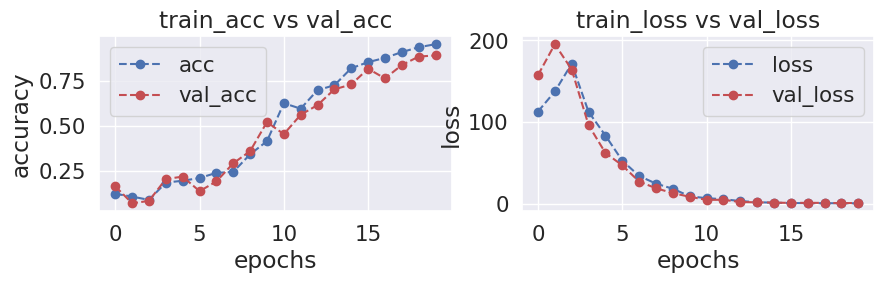

In [51]:
plot_accuracy_loss(history_inception)

6/6 [==============================] - 0s 19ms/step


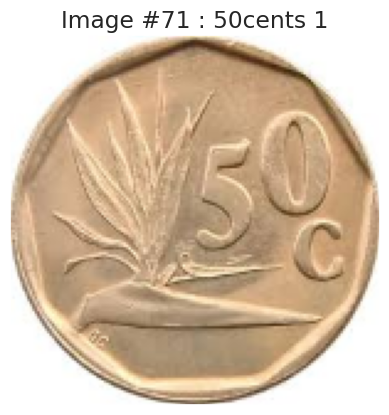

In [52]:
predictions = model_inception.predict(test_images)     # Vector of probabilities
pred_labels_4 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_4)

In [53]:
getTestScore(predictions, test_labels)

................Testing set scores..............................
Testing set accuracy: 0.8540540540540541
Testing set precision: 0.8753040540540542
Testing set recall: 0.8540540540540541
Testing set F1 score: 0.8516242706406639


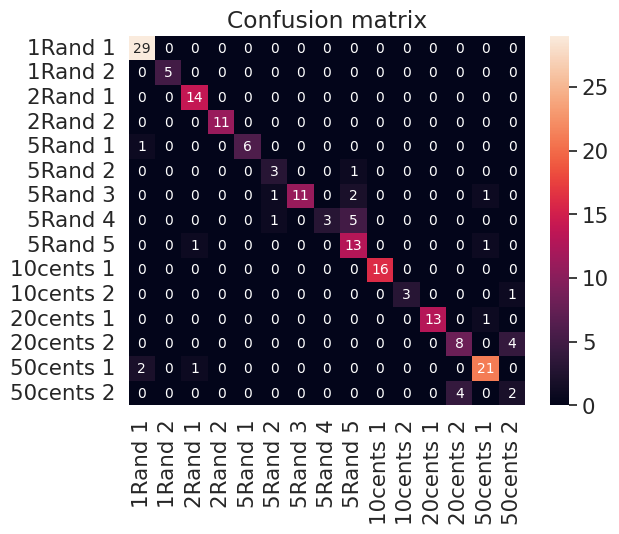

In [54]:
plotConfusionMatrix(test_labels, pred_labels_4)

24/24 [==============================] - 0s 19ms/step


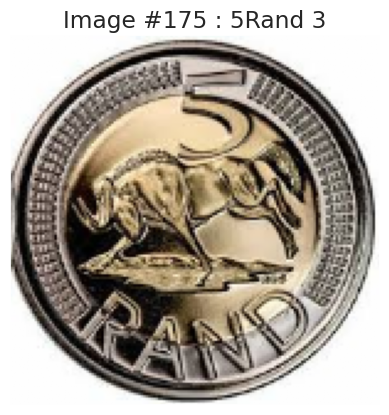

In [55]:
predictions =model_inception.predict(train_images)     # Vector of probabilities
pred_labels_3 = np.argmax(predictions, axis = 1) # We take the highest probability
display_random_image(class_names, test_images, pred_labels_4)

In [56]:
getTrainingScores(predictions, train_labels)

................Training set scores..............................
Training set accuracy: 0.9471544715447154
Training set precision: 0.9598426718395117
Training set recall: 0.9471544715447154
Training set F1 score: 0.9461613265428218
